In [1]:
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/raven/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
from model import RL2, MetaLearner
from evaluate import evaluate_1d
import torch.nn.utils.rnn as rnn_utils
import numpy as np

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Evaluate on left-out train task

In [2]:
from plots import metalearner_evaluation

/raven/u/ajagadish/vanilla-llama/categorisation/rl2/envs.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].apply(lambda x: 0. if x=='A' else 1.) if random_number > 0.5 else data['target'].apply(lambda x: 1. if x=='A' else 0.)
/raven/u/ajagadish/vanilla-llama/categorisation/rl2/envs.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['input'] = data['input'].apply(lambda x: list(map(float, x.strip('[]').split(','))))


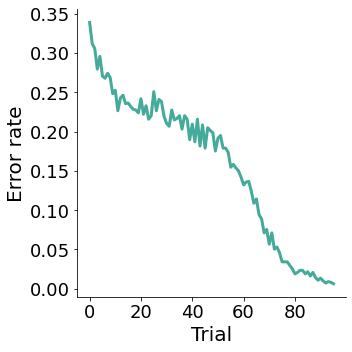

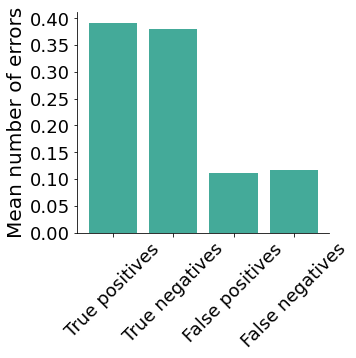

In [10]:
env_name='/raven/u/ajagadish/vanilla-llama/categorisation/data/claude_generated_tasks_paramsNA_dim3_data100_tasks14000.csv'
model_path='/raven/u/ajagadish/vanilla-llama/categorisation/trained_models/env=claude_generated_tasks_paramsNA_dim3_data100_tasks14000_num_episodes100000_num_hidden=128_lr0.0003_run=1.pt'
metalearner_evaluation(env_name, model_path)

## model and training class distribution

In [4]:
 _, model_choices, true_choices, sequences = evaluate_1d(env_name=env_name, \
                  model_path=model_path, \
                  mode='val', return_all=True)

/raven/u/ajagadish/vanilla-llama/categorisation/rl2/envs.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].apply(lambda x: 0. if x=='A' else 1.) if random_number > 0.5 else data['target'].apply(lambda x: 1. if x=='A' else 0.)
/raven/u/ajagadish/vanilla-llama/categorisation/rl2/envs.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['input'] = data['input'].apply(lambda x: list(map(float, x.strip('[]').split(','))))


In [5]:
cum_sum = np.array(sequences).cumsum()
correct = np.ones((len(cum_sum), np.diff(cum_sum).max()))
aa = np.ones((len(cum_sum), np.diff(cum_sum).max()))
bb = np.ones((len(cum_sum), np.diff(cum_sum).max()))
model_choices = model_choices.round()
for task_idx, seq in enumerate(cum_sum[:-1]):
    task_correct = (model_choices==true_choices)[cum_sum[task_idx]:cum_sum[task_idx+1]]
    aa[task_idx,:(cum_sum[task_idx+1]-cum_sum[task_idx])] = model_choices[cum_sum[task_idx]:cum_sum[task_idx+1]]
    bb[task_idx,:(cum_sum[task_idx+1]-cum_sum[task_idx])] = true_choices[cum_sum[task_idx]:cum_sum[task_idx+1]]

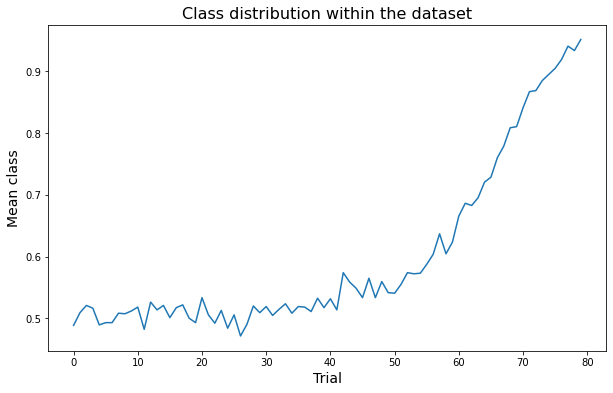

In [6]:
plt.figure(figsize=(10,6))
plt.plot(aa.mean(0)[:80])
plt.title("Class distribution within the dataset", fontsize=16)
plt.xlabel("Trial", fontsize=14)
plt.ylabel("Mean class", fontsize=14)
plt.show()

# Evaluate on Badham et al. 2005 task

In [ ]:
dat = pd.read_csv('../data/human/exp1.csv')
model = torch.load(model_path)[1]
dat['shifted_category'] = np.concatenate((np.array([0.]), dat['category'].values[:-1]))
participants = dat.participant.unique()
conditions = dat.condition.unique()
performance = np.zeros((len(conditions), len(participants)))
per_trial_performance = np.ones((len(conditions), len(participants), 96))
inputs = []
for idx1, cond in enumerate(conditions):
    for idx2, participant in enumerate(participants):
        CONDITION = cond #4
        PARTICIPANT = participant #0
        ## order of features matched to what llm generated order
        inputs = dat[dat.participant==PARTICIPANT][dat.condition==CONDITION][['feature3','feature1','feature2', 'shifted_category']].values #shifted_category
        targets = dat[dat.participant==PARTICIPANT][dat.condition==CONDITION]['category'].values

        inputs = [torch.from_numpy(inputs)]
        packed_inputs = rnn_utils.pad_sequence(inputs, batch_first=True)
        sequence_lengths = [len(x) for x in inputs]

        with torch.no_grad():
            model.eval()
            model_choices = model(packed_inputs, sequence_lengths)
            true_choices = targets.astype(float)
            model_choices = model_choices.view(-1).float().round()
            #print(true_choices.shape, model_choices.shape)
            per_trial_performance[idx1, idx2, :sequence_lengths[0]] = torch.eq(torch.tensor(true_choices), model_choices)
            accuracy = torch.eq(torch.tensor(true_choices), model_choices).sum()/len(model_choices)
        performance[idx1, idx2] = accuracy

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(conditions,  performance.mean(1), yerr= performance.std(1), tick_label=["Type ONE", "Type TWO", "Type THREE", "Type FOUR"])
plt.title("Meta-Learner's performance", fontsize=16)
plt.xlabel("Task Type", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(1-per_trial_performance.mean(1).T,  label=["Type ONE", "Type TWO", "Type THREE", "Type FOUR"])
plt.title("Meta-Learner's performance", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()